In [1]:
from osgeo import gdal

In [2]:
import numpy as np

In [62]:
from tqdm import trange, tqdm

In [28]:
from scipy import interpolate

In [93]:
import random

In [121]:
from sklearn import model_selection, metrics

In [2]:
pip install shapely

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyshp

Note: you may need to restart the kernel to use updated packages.


In [4]:
%run GLCM/functions_GLCM.py

In [5]:
%run technical_functions/geotransform_functions.py

In [6]:
%run technical_functions/ImageToNgs.py

In [122]:
%run technical_functions/cv_and_reclassification.py

In [13]:
def image_to_tensor_interp(X_pan_filename, X_mult_filename, step = 4, window_size = 55, directions = [0], distances = [1], texture_list = ['Autocorrelation', 'ClusterProminence', 'ClusterShade', 'Contrast',
                                                       'Correlation', 'DiffEntropy', 'DiffVariance', 'Dissimilarity', 'Energy',
                                                       'Entropy', 'Homogeneity', 'Homogeneity2', 'InfMeasureCorr1',
                                                      'InfMeasureCorr2', 'MaxProb', 'SumAverage', 'SumEntropy', 
                                                      'SumSquares', 'SumVariance']):
    
    half_size = window_size // 2
    
    X_pan = gdal.Open(X_pan_filename)
    X_mult = gdal.Open(X_mult_filename)
  #  X_pan_rasterio = rxr.open_rasterio(X_pan_filename).squeeze()
  #  X_mult_rasterio = rxr.open_rasterio(X_mult_filename)
    
    m, n = X_pan.ReadAsArray().shape
    _, m_m, m_n = X_mult.ReadAsArray().shape
    
    geo_trans_pan = X_pan.GetGeoTransform()
    geo_trans_mult = X_mult.GetGeoTransform()
    proj_pan = X_pan.GetProjection()
    proj_mult = X_mult.GetProjection()
    
    #тут нужно сделать перевод пикселей мультиканалного изображения в пиксели одноканального изображения
    pixels_pan_list = []
    for i in range(1, m_m + 1):
        a = []
        for j in range(1, m_n + 1):
            a.append((i, j))
        a_coords = pix2coord(a, geo_trans_mult, proj_mult) #были пиксели в мультиканальном, стали координаты
        a_pixels_in_pan = coord2pix(a_coords, geo_trans_pan, proj_pan)
        pixels_pan_list.append(a_pixels_in_pan)
    #теперь в pixels_list лежат листы с пикселями каждой строки
    
    mesh = np.meshgrid(np.arange(0, m_n, step), np.arange(0, m_m, step))
    values = np.zeros((mesh[0].shape[0], mesh[0].shape[1], 19))
    
     #тут нужно отсимметрить все стороны изображения, чтобы посчитать glcm для всех пикселей исходного изображения
    img = copy.deepcopy(X_pan.ReadAsArray())
    upper_part = img[0:half_size, :]
    lower_part = img[m - half_size:m, :]
    img = np.vstack((np.flipud(upper_part), img, np.flipud(lower_part)))
    left_part = img[:, 0:half_size]
    right_part = img[:, n-half_size:n]
    img = np.hstack((np.fliplr(left_part), img, np.fliplr(right_part)))
    
    img = ImageToNgs(img, 64) - 1.
    
    for i in trange(0, len(pixels_pan_list), step): #m_m x m_n
        for j in range(0, len(pixels_pan_list[0]), step):
            x, y = pixels_pan_list[i][j]
            x = int(x + half_size - 1)
            y = int(y + half_size - 1)
            window = copy.deepcopy(img[x - half_size : x + half_size + 1, y - half_size:y + half_size + 1]).astype(int)
            d = to_calc_textures(window, directions, texture_list, distances)
            props = np.array([d[elem] for elem in texture_list]).squeeze()
            values[i // step, j // step, :] = props
            
    values_interpolated = np.zeros((m_m, m_n, 19))
    for i in range(len(texture_list)):
        f = interpolate.interp2d(np.arange(0, m_n, step), np.arange(0, m_m, step), values[:, :, i], kind = 'linear')
        x_ = np.arange(0, m_n)
        y_ = np.arange(0, m_m)
        values_interpolated[:, :, i] = f(x_, y_)
    return values, values_interpolated

In [14]:
x = np.arange(0, 5, 1)
y = np.arange(0, 5, 1)
np.meshgrid(x, y)[0].shape

(5, 5)

In [15]:
X_pan_filename = "geotiff/Konstantinovky_TestReg_pan.tif"
X_mult_filename = "geotiff/Konstantinovky_TestReg_mult.tif"

In [20]:
import sys
import warnings
warnings.filterwarnings("ignore")

In [17]:
len(np.arange(0, 424, 4))

106

In [18]:
np.arange(0, 424, 4)

array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
        52,  56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100,
       104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152,
       156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204,
       208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256,
       260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308,
       312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356, 360,
       364, 368, 372, 376, 380, 384, 388, 392, 396, 400, 404, 408, 412,
       416, 420])

In [21]:
v = image_to_tensor_interp(X_pan_filename, X_mult_filename)

  0%|          | 0/106 [00:00<?, ?it/s]

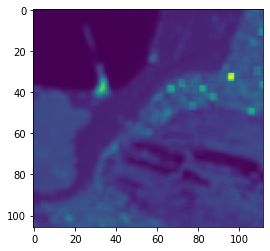

In [27]:
plt.imshow(v[:, :, 0])

In [30]:
v.shape

(106, 112, 19)

In [32]:
m_m = 424
m_n = 448
step = 4
values_interpolated = np.zeros((m_m, m_n, 19))
for i in range(19):
    f = interpolate.interp2d(np.arange(0, m_n, step), np.arange(0, m_m, step), v[:, :, i], kind = 'linear')
    x_ = np.arange(0, m_n)
    y_ = np.arange(0, m_m)
    values_interpolated[:, :, i] = f(x_, y_)

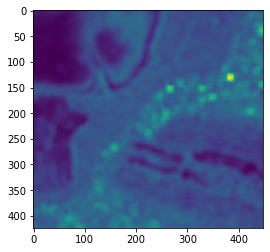

In [40]:
plt.imshow(values_interpolated[:, :, 7])

In [41]:
np.any(np.isnan(values_interpolated))

True

In [56]:
np.any(np.isnan(values_interpolated[:, :, 13])) #layers 4 and 12 have NaN values 

False

In [81]:
T = values_interpolated

In [82]:
T = np.concatenate((T[:, :, :4], T[:, :, 5:12], T[:, :, 13:]), axis = 2)

Загружаем карту.

In [77]:
map_konst = gdal.Open('geotiff/Konstantinovsky_map.tif')
#konstantinovsky_mult = rxr.open_rasterio("geotiff/Konstantinovky_TestReg_mult.tif")
konstantinovsky_mult_gdal = gdal.Open("geotiff/Konstantinovky_TestReg_mult.tif")
konstantinovsky_mult = konstantinovsky_mult_gdal.ReadAsArray()
map_values = map_konst.ReadAsArray()
#map_konst_rasterio = rxr.open_rasterio("Konstantinovsky_map.tif").squeeze()
m_m, m_n = konstantinovsky_mult.shape[1], konstantinovsky_mult.shape[2]
geo_trans_mult = konstantinovsky_mult_gdal.GetGeoTransform()
proj_mult = konstantinovsky_mult_gdal.GetProjection()
geo_trans_pan = map_konst.GetGeoTransform()
proj_pan = map_konst.GetProjection()
pixels_pan_list = []
for i in range(1, m_m + 1):
    a = []
    for j in range(1, m_n + 1):
        a.append((i, j))
    a_coords = pix2coord(a, geo_trans_mult, proj_mult) #были пиксели в мультиканальном, стали координаты
    a_pixels_in_pan = coord2pix(a_coords, geo_trans_pan, proj_pan)
    pixels_pan_list.append(a_pixels_in_pan)
map_konst_ = np.zeros((T.shape[0], T.shape[1]))
cnt_i = 0
cnt_j = 0
for line in tqdm(pixels_pan_list):
    cnt_j = 0
    for elem in line:
        i, j = elem
        i = int(i - 1)
        j = int(j - 1)
        map_konst_[cnt_i][cnt_j] = map_values[i][j]
        cnt_j += 1
    cnt_i += 1

100%|███████████████████████████████████████████| 424/424 [00:00<00:00, 453.95it/s]


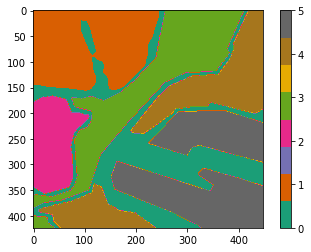

In [78]:
plt.imshow(map_konst_, cmap=plt.get_cmap('Dark2'))
plt.colorbar()

In [83]:
import skimage.io
import skimage.filters

sigma = 7.0
for i in range(17):
    T[:, :, i] = skimage.filters.gaussian(
        T[:, :, i], sigma=(sigma, sigma), truncate=3.5, multichannel=False)

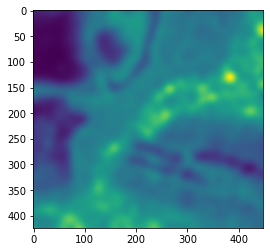

In [84]:
plt.imshow(T[:, :, 6])

In [87]:
from sklearn.preprocessing import StandardScaler
T = T.reshape((T.shape[0] * T.shape[1], 17))
scaler = StandardScaler()
T = scaler.fit_transform(T)

In [88]:
map_konst_ = map_konst_.reshape((map_konst_.shape[0] * map_konst_.shape[1], 1))

In [89]:
data = np.concatenate((T, map_konst_), axis = 1)

In [94]:
ones = data[np.argwhere(map_konst_.squeeze() == 1), :].squeeze()
data_ = np.array(random.sample(list(ones), 10000))
for i in range(2, 6):
    tmp = data[np.argwhere(map_konst_.squeeze() == i), :].squeeze()
    data_ = np.concatenate((data_, np.array(random.sample(list(tmp), 10000))), axis = 0)

In [96]:
X = data_[:, :17]
y = data_[:, 17]

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [99]:
from sklearn.neighbors import KNeighborsClassifier

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=0, stratify = y) 

In [101]:
qda = QuadraticDiscriminantAnalysis()

In [102]:
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [103]:
pred_qda = qda.predict(T.reshape(424 * 448, 17))

In [104]:
p = pred_qda.reshape((424, 448))

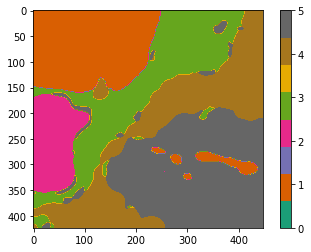

In [105]:
plt.imshow(pred_qda.reshape(424, 448), cmap=plt.get_cmap('Dark2'), vmin=0, vmax=5)
plt.colorbar()

In [123]:
q = QuadraticDiscriminantAnalysis()
mt = model_test(q, X_train, y_train, ['1', '2', '3', '4', '5'])
mt

(<pandas.io.formats.style.Styler at 0x7fa928d4fbd0>,
 [  10-fold cross-validation                                       \
              Omission error Commission error Producer’s accuracy   
  1                 0.000101         0.000000            0.999899   
  2                 0.003288         0.000000            0.996712   
  3                 0.042716         0.013395            0.957284   
  4                 0.002593         0.029094            0.997407   
  5                 0.015303         0.018157            0.984697   
  
                     
    User’s accuracy  
  1        1.000000  
  2        1.000000  
  3        0.986605  
  4        0.970906  
  5        0.981843  ,
    Reclassification                                                     
      Omission error Commission error Producer’s accuracy User’s accuracy
  1         0.000101         0.000000            0.999899        1.000000
  2         0.003333         0.000000            0.996667        1.000000
  3       